## Ruben Abbou
### Adaptive Integration in Two Dimensions
Approximation of integrals of real-valued functions $f(x,y)$ over a rectangle $[x_1, x_2]\times[y_1, y_2]$. The integrals are approximated by the two-dimensional version of the midpoint rule:

$$\int_{x_1}^{x_2}\int_{y_1}^{y_2}f(x,y)dxdy = f(x_m, y_m)(x_2-x_1)(y_2-y_1)$$

where $x_m = \frac{x_1+x_2}{2}, y_m = \frac{y_1+y_2}{2}$.

In [1]:
from numpy import array, zeros
from math import factorial as fact
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def mid_point(f, rect):
    '''
    Midpoint rule approximation for f on a given rectangle
    Inputs:
        - f: function which integral we want to approximate
        - rec: rectangle on which we want to approximate this integral
    Output: mid point rule approximation
    '''
    x1, x2, y1, y2 = rect
    return f((x1 + x2) / 2, (y1 + y2) / 2) * (x2 - x1) * (y2 - y1)

def twoD_adapt_int(f, rect, TOL, level=0, minLevel = 3, maxLevel = 30):
    '''
    2D Adaptive Integration of a function with recursive scheme
    Inputs:
        - f: function which integral we want to approximate
        - rec: rectangle on which we want to approximate this integral
        - TOL: approximation tolerance
        - level: recursion level
    Outputs:
        - F_approx: approximation of the integral of f
        - hist: list of rectangles used throughout the approximation
    '''
    assert level <= maxLevel
    x1, x2, y1, y2 = rect
    assert x2 > x1 and y2 > y1
    hist = [rect] # add to history since adaptive function is called on this rectangle
    
    xm = (x1 + x2) / 2
    ym = (y1 + y2) / 2
    
    # Calculate approximation
    F_coarse = mid_point(f, rect)
    rectangles = [(x1, xm, y1, ym), (xm, x2, y1, ym), (x1, xm, ym, y2), (xm, x2, ym, y2)]
    F_fine = sum([mid_point(f, rect) for rect in rectangles])
    
    if abs(F_coarse - F_fine) <= TOL and level >= minLevel or level == maxLevel:
        # good approximation
        return (4 * F_fine - F_coarse) / 3, hist
    else:
        # recursion
        F_approx = 0
        for r in rectangles:
            F_rec, h_rec = twoD_adapt_int(f, r, TOL/4, level+1, minLevel, maxLevel)
            F_approx += F_rec
            hist += h_rec
        return F_approx, hist

### Polynomials $f(x, y) = x^iy^j$ on $[0,1]\times[0,1]$ for $i, j = 0, 1, 2, 3, 4$

The true solution for these integrals is:

\begin{align*}
\int_{0}^{1}\int_{0}^{1}x^iy^jdxdy &= \int_{0}^{1} y^j \cdot \left[\frac{x^{i+1}}{i+1}\right]_0^1dy \\
&= \frac{1-0}{i+1} \cdot \left[\frac{y^{i+1}}{i+1}\right]_0^1\\
&= \frac{1}{(i+1)(j+1)}
\end{align*}

since $i+1, j+1 > 0$ for $i, j \ge 0$.

In [3]:
results = zeros((5,5))
exact = zeros((5,5))
for i in range(5):
    for j in range(5):
        f = lambda x, y: x**i * y**j
        tol = 0.01/(fact(i+1)*fact(j+1))
        results[i,j] = twoD_adapt_int(f, (0,1,0,1), tol)[0]
        exact[i,j] = 1/((i+1)*(j+1))
        
error = DataFrame(abs(results - exact), columns=[str(i) for i in range(5)],
                       index = [str(i) for i in range(5)])

The errors in the approximations for each combination of degrees $i, j$ are:

In [4]:
error

,0,1,2,3,4
0,0.000000e+00,0.000000e+00,5.551115e-17,0.000000e+00,2.381647e-07
1,0.000000e+00,0.000000e+00,2.775558e-17,0.000000e+00,1.260999e-07
2,5.551115e-17,2.775558e-17,1.037131e-07,3.580471e-08,4.534319e-08
3,0.000000e+00,0.000000e+00,3.580471e-08,1.136896e-08,8.426341e-09
4,2.381647e-07,1.260999e-07,4.534319e-08,8.426341e-09,2.614076e-09


Let's check which of these polynomials are integrated exactly and have error 0 (python has an arithmetic error of about $10^{-12}$):

In [5]:
error < 1e-12

,0,1,2,3,4
0,True,True,True,True,False
1,True,True,True,True,False
2,True,True,False,False,False
3,True,True,False,False,False
4,False,False,False,False,False


As expected, the mid-point rule is exact for polynomials that are of separate degree at most one ($x^0y^0, x^0y^1, x^1y^0, x^1y^1$). Additionally, we observe an exact solution for the following polynomials: $y^2, y^3, xy^2, xy^3, x^2, x^3, yx^2, yx^3$. This is due to the fact that if one of the two variables is of degree at most one, then the mid-point rule will integrate the remaining factor exactly if its degree is at most 3.

### Unit Circle
$$\text{ Integrate }\quad f(x, y) = \begin{cases} 1 &\text{ if }\ x^2+y^2 < 1 \\ 0 &\text{ otherwise } \end{cases}\quad \text{ over the square } \quad [-1,1]\times[-1,1]$$

In [6]:
f = lambda x, y: 1 if x**2 + y**2 < 1 else 0
F_app, history = twoD_adapt_int(f, (-1,1,-1,1), .001, maxLevel = 10)

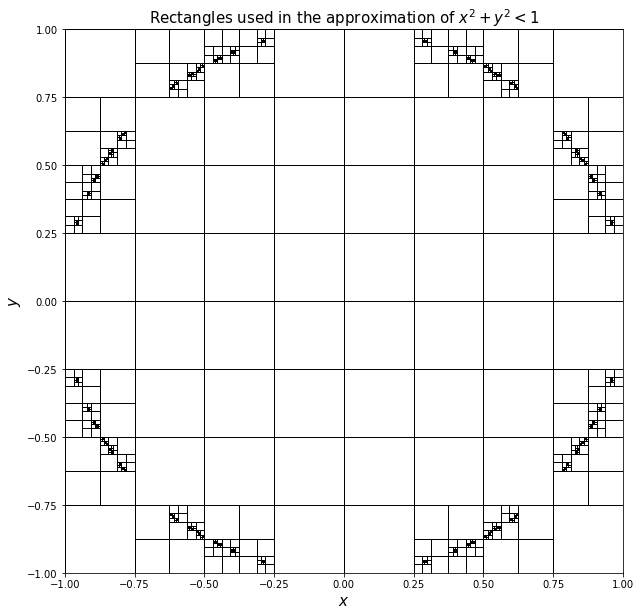

In [7]:
fig,ax = plt.subplots(1, figsize=(10,10))
for rect in history:
    ax.add_patch(Rectangle((rect[0], rect[2]), fill=False,
                            width=rect[1]-rect[0], height=rect[3]-rect[2]))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r'$x$', size=15)
plt.ylabel(r'$y$', size=15)
plt.title(r'Rectangles used in the approximation of $x^2+y^2<1$', size=15)
plt.show()